In [1]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200, precision=3)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [3]:
from diffusers import StableDiffusionPipeline
from diffusers import EulerDiscreteScheduler
from diffusers import ControlNetXSModel
from diffusers import StableDiffusionControlNetXSPipeline

In [4]:
sd_pipe = StableDiffusionPipeline.from_single_file('weights/sd21/v2-1_512-ema-pruned.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs-sd-canny').to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `requires_safety_checker` directly via 'StableDiffusionPipeline' object attribute is deprecated. Please access 'requires_safety_checker' over 'StableDiffusionPipeline's config object instead, e.g. 'scheduler.config.

In [5]:
assert cnxs.control_model.down_blocks[1].attentions[0].transformer_blocks[0].attn1.heads==1
assert cnxs.control_model.down_blocks[2].attentions[0].transformer_blocks[0].attn1.heads==2

In [6]:
cnxs.base_model = sd_pipe.unet

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [7]:
scheduler_cgf = dict(sd_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sd_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sd_pipe.scheduler.set_timesteps(50)
assert sd_pipe.scheduler.timesteps[0]==999

# reset
sd_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

In [8]:
cnxs_pipe = StableDiffusionControlNetXSPipeline.from_single_file(
    'weights/sd21/v2-1_512-ema-pruned.safetensors', controlnet=cnxs
).to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs.StableDiffusionControlNetXSPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/Users/umer/Documents/GitHub/diffusers/diffusers/src/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `requires_safety_checker` directly via 'StableDiffusionControlNetXSPipeline' object attribute is deprecated. Please access 'requires_safety_checker' over 'StableDiffusionControlNetXSPipeline's config object in

___

## Run

In [9]:
import torch
import random
import numpy as np
import cv2
from diffusers.utils import load_image
import matplotlib.pyplot as plt

class CannyDetector:
    def __call__(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

def get_canny_edges(image, threshold=(100, 250)):
    image = np.array(image).astype(np.uint8)
    edges = CannyDetector()(image, *threshold)  # original sized greyscale edges
    return edges

def seed_everything(seed):
    # paper used deprecated `seed_everything` from pytorch lightning
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)

RANDOM_SEED_IN_PAPER = 1999158951

In [10]:
latents_sdxl_cloud = torch.load('latents_cloud_no_control.pth', map_location=torch.device(device))
rand_from_cloud = latents_sdxl_cloud[0] / 14.6146

In [11]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
neg_prompt = 'lowres, bad anatomy, worst quality, low quality'

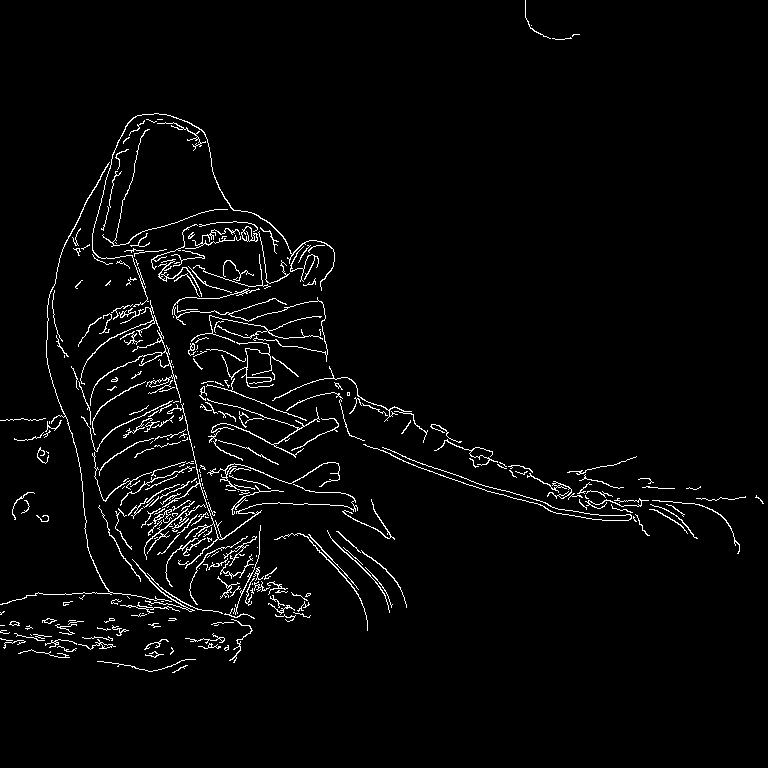

In [12]:
from PIL import Image 

image = load_image('input_images/shoe_cloud.png')

edges = get_canny_edges(image)
edges = edges[:, :, None]
edges = np.concatenate([edges, edges, edges], axis=2)

canny_image = Image.fromarray(edges)

canny_image

In [13]:
from functools import partial
from util_plot import save_latents

In [14]:
seed_everything(RANDOM_SEED_IN_PAPER)
result = cnxs_pipe(prompt, negative_prompt=neg_prompt,image=canny_image, controlnet_conditioning_scale=.95)

  0%|          | 0/50 [00:00<?, ?it/s]

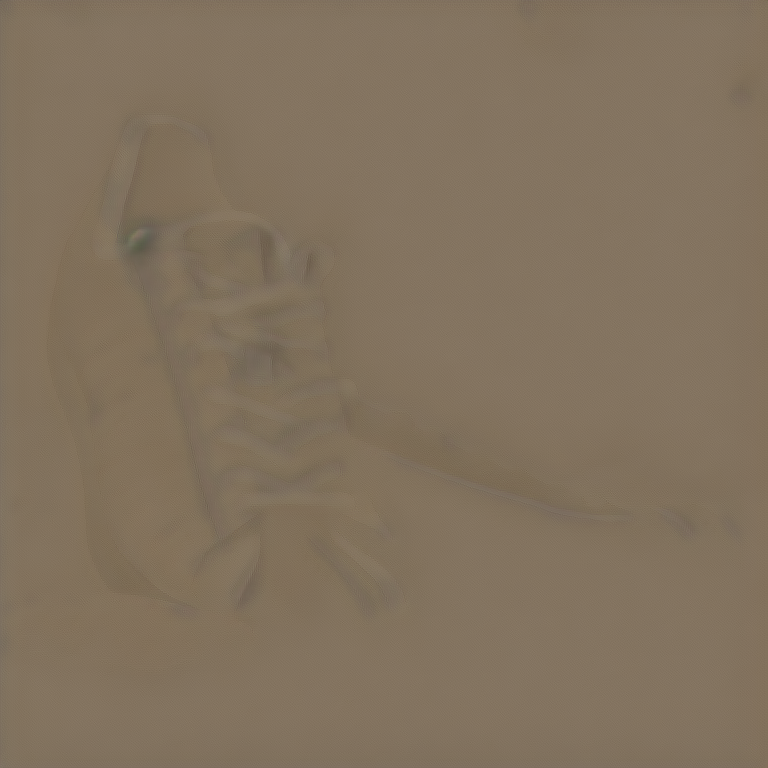

In [15]:
result.images[0]